<img src='./img/logoline_12000.png' align='center' width='100%'></img>

# Tutorial on Copernicus ECMWF Data Access
In this tutorial we will access and view data from both the Copernicus Climate Change Service (C3S) and the Copernicus Atmosphere Monitoring Service (CAMS). The tutorial comprises the following steps:

[Prepare environment](#prepare)

1. Prepare your environment including registering with the Climate and Atmosphere Data Stores (CDS and ADS) of C3S and CAMS respectively, and obtaining Application Programming Interface (API) keys for both catalogues.

[C3S ERA5 soil moisture & CAMS fire data](#era5_fire)

2. Search and download ERA5 soil moisture data from the CDS using the CDS API.
3. Calculate soil moisture anomalies.
4. Read preprocessed Fire Radiative Power (FRP) data from CAMS.
5. View and plot soil moisture data, and compare with fire locations.

[CAMS European air quality forecast data](#EurAQ)

6. Download CAMS European air quality forecast data (dust and PM10) from ADS.
7. View both dust and PM10 data in separate plots.

[CAMS near-real-time global AOD](#AOD)

8. Download total AOD data from 5 days ago using the CAMS catalogue.
9. View the data in a plot.

## <a id='prepare'></a>Prepare environment

Before we begin we must prepare our environment. You will not need to install any software for the training, but if you want to adapt the exercise to your own needs you will need to install the CDS API (`pip install cdsapi`), in addition to Jupyter and Python. You will also need various Python libraries, in particular Xarray http://xarray.pydata.org/en/stable/. Given that most of the Python libraries we will need for this tutorial are included in the Anaconda distribution, if you do wish to set-up your own environment, it is recommended to install Anaconda https://docs.anaconda.com/anaconda/install/.

### Register with CDS and ADS

To register with the Climate and Atmosphere Data Stores (CDS/ADS) visit https://cds.climate.copernicus.eu/ and https://ads.atmosphere.copernicus.eu respectively, and select **"Login/Register"**

<img src='./img/CDS_login.png' align='left' width='60%'></img>

### Obtain CDS/ADS API keys

Before you can request data from the CDS/ADS, you will need to register on the CDS website and obtain a User ID and API Key. In order to do so, please follow the steps at these links:

- To obtain CDS API key: https://cds.climate.copernicus.eu/api-how-to
- To obtain ADS API key: https://ads.atmosphere.copernicus.eu/api-how-to

Once you have a User ID and API Key for both the CDS and ADS, insert these into the variables in the cell below. I.e. substitute `CDS_UID` with your CDS User ID, `CDS_API_KEY` with your CDS API key, `ADS_UID` with your ADS User ID and `ADS_API_KEY` with your ADS API key.

In [55]:
CDS_URL = "https://cds.climate.copernicus.eu/api/v2"
ADS_URL = "https://ads.atmosphere.copernicus.eu/api/v2"

# enter your CDS authentication key:
CDS_KEY = "CDS_UID:CDS_API_KEY"

# enter your ADS authentication key:
ADS_KEY = "ADS_UID:ADS_API_KEY"

### Import libraries

We now need to import the libraries needed for our analyses:

In [1]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import pandas as pd
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

Here we specify a data directory:

In [5]:
DATADIR = './data'

## <a id='era5_fire'></a>C3S ERA5 soil moisture & CAMS fire data

### Search for data on the CDS

To search for data, visit the CDS website: http://cds.climate.copernicus.eu To facilitate your search you can use keywords, or apply various filters.

The data we are going to use in this exercise is the ERA5 monthly averaged reanalysis data on single levels from 1979 to present. We are going to download volumetric soil water at layer 1. This parameter is the volume of water in soil layer 1 (0 - 7cm, the surface is at 0cm). We will download data only over the Arctic. We would like to view the anomalies for summer 2019, but the data comes in monthly means. To calculate the anomalies we will subtract from the 2019 data the average of the time series from 1981 to 2010.

Using the filters, or keywords, search for the dataset `ERA5 monthly averaged data on single levels from 1979 to present`.

<img src='./img/CDS.jpg' align='left' width='45%'></img> <img src='./img/CDS_ERA5.jpg' align='right' width='45%'></img> 

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

- Product type: `Monthly averaged reanalysis`
- Variable: `Volumetric soil water layer 1`
- Year: `1981,...2010,2019`
- Month: `June, July, August`
- Time: `00:00` (default)
- Geographical area: `North: 90`, `East: 180`, `South: 66`, `West: -180` 
- Format: `NetCDF`

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below)...

### Download data using CDS API

Having copied the API request into the cell below, running this will retrieve and download the data you requested into your specified directory.

In [ ]:
c = cdsapi.Client(url=CDS_URL, key=CDS_KEY)
c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': 'volumetric_soil_water_layer_1',
        'year': [
            '1981', '1982', '1983',
            '1984', '1985', '1986',
            '1987', '1988', '1989',
            '1990', '1991', '1992',
            '1993', '1994', '1995',
            '1996', '1997', '1998',
            '1999', '2000', '2001',
            '2002', '2003', '2004',
            '2005', '2006', '2007',
            '2008', '2009', '2010',
            '2019',
        ],
        'month': [
            '06', '07', '08',
        ],
        'time': '00:00',
        'area': [
            90, -180, 66,
            180,
        ],
        'format': 'netcdf',
    },
    f'{DATADIR}/ERA5_vsm.nc')

### Read ERA5 data

Now that we have downloaded the data, we can read, plot and analyse it...

We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. 

To read and process this data we will make use of the Xarray library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an Xarray **"dataset"**.

First we create a variable with the name of our downloaded file:

In [6]:
fn = f'{DATADIR}/ERA5_vsm.nc'

Now we can read the data into an Xarray dataset:

In [7]:
# Create Xarray Dataset
ds = xr.open_dataset(fn)

Let's see how this looks by querying our newly created Xarray dataset ...

In [8]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 97, longitude: 1440, time: 93)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 66.5 66.25 66.0
  * time       (time) datetime64[ns] 1981-06-01 1981-07-01 ... 2019-08-01
Data variables:
    swvl1      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-20 11:04:20 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

We see that the dataset has one variable called **"swvl1"**, which stands for "volumetric_soil_water_layer_1", and three coordinates of **longitude**, **latitude** and **time**.

While an Xarray **dataset** may contain multiple variables, an Xarray **data array** holds a single multi-dimensional variable and its coordinates. To make the processing of the **swvl1** data easier, we convert in into an Xarray data array.

In [9]:
# Create Xarray Data Array
da = ds['swvl1']

### View and plot soil moisture data, and compare with fire locations

Now the fun part begins! Once our data is in a convenient format, there is no limit to what we can do with it! For example we can finally visualise the data to see what information it can provide.

We are interested in viewing anomalies for 2019 with respect to the long term average, so we will first need to calculate the reference average for the period 1981 to 2010.

For efficiency we first calculate the yearly means (average of JJA for each year):

In [10]:
yearly_mean = da.groupby('time.year').mean('time')

Here we subset data for the period 1981 to 2010:

In [11]:
ref = yearly_mean.where((yearly_mean.year > 1980) & (yearly_mean.year < 2011), drop=True)

Now we can calculate the mean for 1981-2010:

In [12]:
ref_mean = ref.mean(dim="year")

Here we calculate the yearly mean for 2019:

In [13]:
swv_2019 = yearly_mean.where((yearly_mean.year == 2019), drop=True)
swv_2019 = swv_2019.mean(dim="year")

### Calculate anomalies

We will now calculate anomalies, defined as deviations from the reference mean.

In [14]:
swv_an_2019 = swv_2019 - ref_mean

Let's inspect the newly created anomaly data

In [15]:
swv_an_2019

<xarray.DataArray 'swvl1' (latitude: 97, longitude: 1440)>
array([[ 1.4210855e-13,  1.4210855e-13,  1.4210855e-13, ...,
         1.4210855e-13,  1.4210855e-13,  1.4210855e-13],
       [ 1.4210855e-13,  1.4210855e-13,  1.4210855e-13, ...,
         1.4210855e-13,  1.4210855e-13,  1.4210855e-13],
       [ 1.4210855e-13,  1.4210855e-13,  1.4210855e-13, ...,
         1.4210855e-13,  1.4210855e-13,  1.4210855e-13],
       ...,
       [-1.3383687e-02, -9.9414587e-03, -4.8720837e-03, ...,
         1.6953945e-03, -2.6411116e-03, -9.9717081e-03],
       [ 9.6029043e-03,  2.9694587e-03, -3.7146211e-03, ...,
         3.6236346e-03, -3.1501055e-04,  4.6666861e-03],
       [-2.6646852e-03, -8.5413456e-03, -3.4183040e-03, ...,
         9.6756220e-03,  3.5119653e-03, -6.5770745e-03]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 66.5 66.25 66.0

### Read Fire Radiative Power (FRP) data from CAMS catalogue

We would like to compare the soil moisture data in the Arctic with fire locations. These we can obtain from the CAMS Catalogue https://atmosphere.copernicus.eu/catalogue#/, from the dataset: `NRT Biomass burning emissions of carbon and various trace species based on assimilated Fire Radiative Power (FRP) (GFAS)`. Following the links in the CAMS Catalogue will lead you to the CAMS Global Fire Assimilation System (GFAS) catalogue https://apps.ecmwf.int/datasets/data/cams-gfas/, where you can select the various parameters, date ranges, etc. that you are interested in.

For the purposes of this tutorial, and to reduce the data volume, we will use a preprocessed version of the fire radiative power data. This is available in your data folder with the name `cams_gfas_arctic_jun-aug_2019.csv`.

In [16]:
fn = f'{DATADIR}/cams_gfas_arctic_jun-aug_2019.csv'
df = pd.read_csv(fn)

Let's view this data:

In [17]:
df

,Date,Longitude (deg E),Latitude (deg N),Wildfire radiative power (Gigawatts per day)
0,20190601,-51.65,67.35,0.002496
1,20190601,-51.65,67.85,0.007972
2,20190601,70.95,66.15,0.012929
3,20190601,70.95,66.25,0.029266
4,20190601,71.05,66.15,0.011182
...,...,...,...,...
16617,20190831,136.45,67.45,0.005863
16618,20190831,136.75,67.65,0.001069
16619,20190831,140.55,69.25,0.041437
16620,20190831,140.65,69.25,0.002047


In [18]:
# rename columns for simplicity
df.rename(columns={"Longitude (deg E)": "longitude", 
                   "Latitude (deg N)": "latitude", 
                   "Wildfire radiative power (Gigawatts per day)": "frp"}, 
          inplace=True)

### View and plot soil moisture data, and compare with fire locations

Now we can compare the soil moisture anomalies in the Arctic for JJA 2019, with fire locations for the same period in a map:

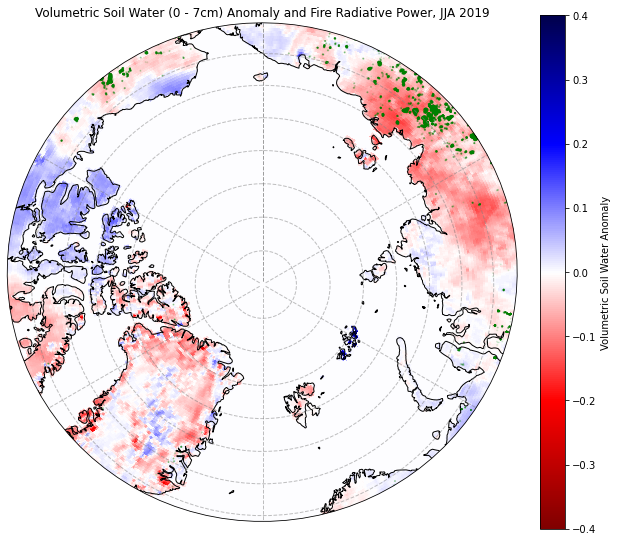

In [19]:
# create the figure panel 
fig = plt.figure(figsize=(10,10))

# create the projections
ortho = ccrs.Orthographic(central_longitude=0, central_latitude=90)
geo = ccrs.Geodetic()

# create the map using the cartopy Orthographic projection, selecting the North Pole
ax = plt.subplot(1,1,1, projection=ortho)

# transform lat/lons points to othographic points
points = ortho.transform_points(geo, df['longitude'].values, 
                                    df['latitude'].values)
# add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

# compute a circle in axes coordinates, which we can use as a boundary for the map.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# set boundary
ax.set_extent([-180,180, 66.05,90], crs=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

# provide a title
ax.set_title('Volumetric Soil Water (0 - 7cm) Anomaly and Fire Radiative Power, JJA 2019', fontsize=12)

# plot FRP

im = plt.pcolormesh(swv_an_2019.longitude.values, swv_an_2019.latitude.values,
                    swv_an_2019, cmap='seismic_r', vmin=-0.4, vmax=0.4, transform=ccrs.PlateCarree())
ax.scatter(points[:, 0], points[:, 1], 
           c='green', s=(2**df['frp']), alpha=0.1, label='FRP')

# add colourbar
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label(label='Volumetric Soil Water Anomaly')

# save figure as PNG file
fig.savefig(f'{DATADIR}/SM_FRP_JJA2019.png')

## <a id='EurAQ'></a>CAMS European air quality forecast data

In this part of the tutorial we will download CAMS European air quality forecast data from the ADS https://ads.atmosphere.copernicus.eu. The ADS is very similar to the CDS and has the same keyword and filters functionality to refine your search. We will search for the following dataset: `CAMS European air quality forecasts`.

Having selected the correct dataset, we now need to specify what variable, parameters and temporal coverage we are interested in. These can all be specified in the **"Download data"** tab. In this tab, just as with the CDS, a form appears in which we will select the following parameters to download:

- Variable: `Dust` and `Particulate matter < 10 µm (PM10)`
- Model: `Ensemble median`
- Level: `0` (height in meters)
- Date: Start: `2021-02-20`, End: `2021-02-20`
- Type: `Analysis` (default)
- Time: `12:00` 
- Leadtime hour: `0` (default for analysis)
- Area: `Full model area`
- Format: `NetCDF`

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below)...

### Download data from ADS

Having copied the API request into the cell below, running this will retrieve and download the data you requested into your specified directory.

In [56]:
c = cdsapi.Client(url=ADS_URL, key=ADS_KEY)
c.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'variable': [
            'dust', 'particulate_matter_10um',
        ],
        'model': 'ensemble',
        'level': '0',
        'date': '2021-02-20/2021-02-20',
        'type': 'analysis',
        'time': '12:00',
        'leadtime_hour': '0',
        'format': 'netcdf',
    },
    f'{DATADIR}/CAMS_AirQuality_20210220.nc')

C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-02-21 16:27:00,718 INFO Welcome to the CDS
2021-02-21 16:27:00,722 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-02-21 16:27:00,805 INFO Request is queued
C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS reque

Result(content_length=2357960,content_type=application/x-netcdf,location=https://download-0001.copernicus-atmosphere.eu/cache-compute-0001/cache/data8/adaptor.cams_regional_fc.retrieve-1613924820.3752525-31115-16-0b8f3a25-3cb1-4f87-89f0-7e3d773cb33c.nc)

### Read CAMS air quality data and inspect metadata

We will now read and inspect this data:

In [58]:
# Create filename variable
fn = f'{DATADIR}/CAMS_AirQuality_20210220.nc'
# Read the air quality data into an xarray data-set
ds_aq = xr.open_dataset(fn)

In [59]:
# Inspect the data (note the two variables of dust and PM10)
ds_aq

<xarray.Dataset>
Dimensions:    (latitude: 420, level: 1, longitude: 700, time: 1)
Coordinates:
  * longitude  (longitude) float32 335.05 335.15 335.25 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level      (level) float32 0.0
  * time       (time) timedelta64[ns] 12:00:00
Data variables:
    dust       (time, level, latitude, longitude) float32 ...
    pm10_conc  (time, level, latitude, longitude) float32 ...
Attributes:
    title:        Dust/PM10 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210220+[12H_12H]
    summary:      ENSEMBLE model hourly ANALYSIS of Dust/PM10 concentration a...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

### Plot map of dust over Europe

Let's look more closely at the dust data:

In [60]:
# Create a data array of just the dust data:
dust = ds_aq['dust']
# as there is only one level and one time, we can remove
# these by dropping all coordinates with only one entry
dust = dust.squeeze(drop=True)

We can visualise this data by plotting it onto a map of Europe:

In [67]:
# This code is just to create a colour map similar to that used in CAMS products.

matrix = np.array([[255, 255, 255],
                   [210, 214, 234],
                   [167, 174, 214],
                   [135, 145, 190],
                   [162, 167, 144],
                   [189, 188, 101],
                   [215, 209, 57],
                   [242, 230, 11],
                   [243, 197, 10],
                   [245, 164, 8],
                   [247, 131, 6],
                   [248, 98, 5],
                   [250, 65, 3],
                   [252, 32, 1],
                   [254, 0, 0]])
n = 17
cams = np.ones((255, 4))
for i in range(matrix.shape[0]):
    cams[(i*n):((i+1)*n), :] = np.array([matrix[i,0]/255, matrix[i,1]/255, matrix[i,2]/255, 1])
camscmp = ListedColormap(cams)

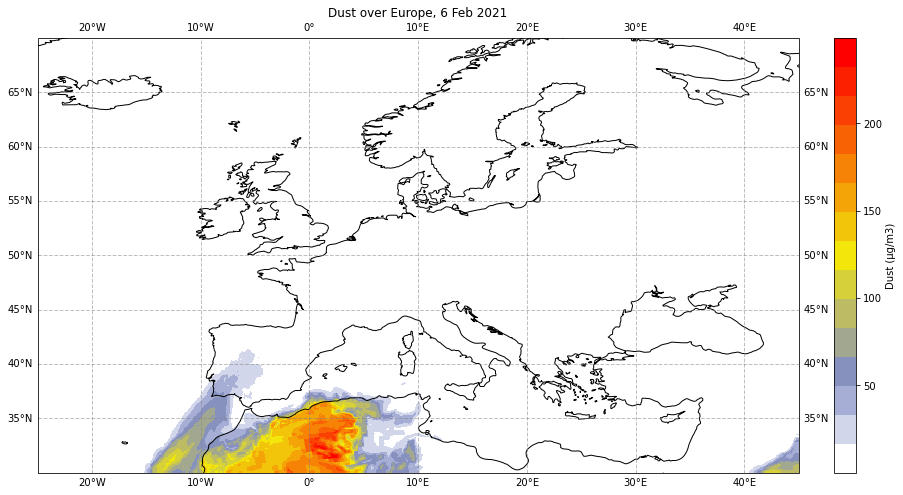

In [68]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines(color='black')
ax.set_extent([-25,45,30,70], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_title('Dust over Europe, 6 Feb 2021', fontsize=12)
im = plt.pcolormesh(dust['longitude'].values, dust['latitude'].values,
                    dust, cmap=camscmp, transform=ccrs.PlateCarree())
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Dust (µg/m3)')
fig.savefig(f'{DATADIR}/Dust_Europe_20210220.png')

### Plot map of PM10 over Europe

Let us now compare this with a map of the other variable: PM10

In [69]:
pm10 = ds_aq['pm10_conc']
pm10 = pm10.squeeze(drop=True)

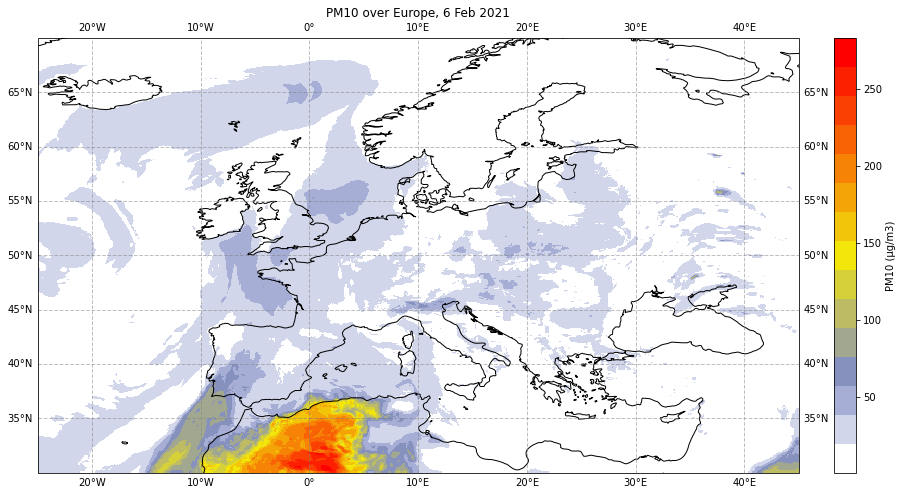

In [70]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines(color='black')
ax.set_extent([-25,45,30,70], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_title('PM10 over Europe, 6 Feb 2021', fontsize=12)
im = plt.pcolormesh(pm10['longitude'].values, pm10['latitude'].values,
                    pm10, cmap=camscmp, transform=ccrs.PlateCarree())
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('PM10 (µg/m3)')
fig.savefig(f'{DATADIR}/PM10_Europe_20210220.png')

## <a id='AOD'></a>CAMS near-real-time global AOD

In this final part of the tutorial we will retrieve near real-time (older than five days) data for total Aerosol Optical Depth (AOD) at 550 nm, from the CAMS catalogue https://atmosphere.copernicus.eu/catalogue#/. This catalogue contains a large number of freely accessible datasets, categorised into product and parameter groups. 

The dataset we will use is accessible through the catalogue, but can ultimately be downloaded from the CAMS Near-real-time download form https://apps.ecmwf.int/datasets/data/cams-nrealtime/levtype=sfc/.

We will use this web form to download the following dataset:

- Month: `Feb 2021`
- Time: `00:00`
- Step: `0` (lead time)
- Parameter: `Total Aerosol Optical Depth at 550nm`

Having selected the fields above, click `Retrieve NetCDF`. This will lead you to a summary page where you can submit your request. As soon as this has been processed, a link will be provided to download the data.

This data has already been downloaded for you and provided in your `data` directory. We will open it and create a plot.

### Read NRT data on total AOD at 550nm

In [71]:
fn = f'{DATADIR}/CAMS_NRT_AOD.nc'
ds_aod = xr.open_dataset(fn)

In [72]:
ds_aod

<xarray.Dataset>
Dimensions:    (latitude: 451, longitude: 900, time: 14)
Coordinates:
  * longitude  (longitude) float32 0.0 0.4 0.8 1.2 ... 358.4 358.8 359.2 359.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2021-02-01T18:00:00 ... 2021-02-14T18:00:00
Data variables:
    aod550     (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-19 22:47:05 GMT by grib_to_netcdf-2.19.1: grib_to_n...

Notice how there are 14 time steps in the dataset corresponding to the days in February up to 5 days ago.

In [73]:
# Create xarray dataset
aod = ds_aod['aod550']

### Creat global map of total AOD at 550nm

We can create a 2d plot for each of the time steps, which we can access by indexing the time coordinate:

In [74]:
aod_step01 = aod[0, :, :]

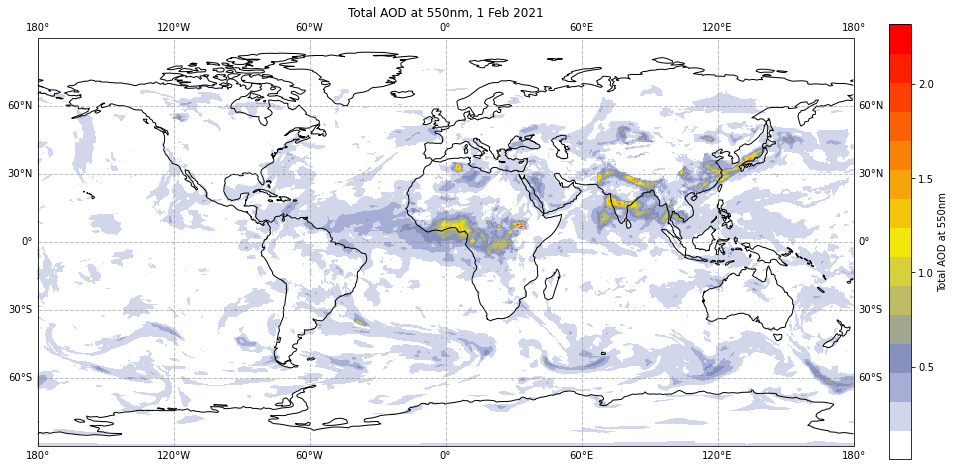

In [75]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_title('Total AOD at 550nm, 1 Feb 2021', fontsize=12)
im = plt.pcolormesh(aod_step01['longitude'].values, aod_step01['latitude'].values,
                    aod_step01, cmap=camscmp, transform=ccrs.PlateCarree())
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Total AOD at 550nm')
fig.savefig(f'{DATADIR}/AOD_20210201.png')